# Data (aka the environment)

For classic ML problems, we need a lot of data to make good predictions given the features. Reinforcement learning (RL) problem is a bit different, but the bit about data is also true.

![RL Loop](rl.png)

In RL, we have three main pieces of signal from which the model will make predictions: state, action, and reward. These will inform the policy that dictates the action of the agent on how to behave to improve.

## Environment Description

The RL environments come in many shapes and forms, but the distinctive feature of all of them is that they follow the structure from the picture above. They have some environment with which the agent interacts, and it gets the information about its current state and rewards from its actions. Having this mental model allows us to structure many problems as RL. 

For example, self-driving: 

- state: the state could be the visuals from the onboard camera, velocity, pedal positions, etc.
- reward: this can be tricky, but to make it a simple example, suppose that for every second the model drives without a crash, it gets 1, and -1000 for a crash. The reward function design can be tricky because the model could figure out that not driving could be the most effective way to maximize the reward :).
- action: this can also be modeled in different ways, but for the sake of simplicity, imagine the model can rotate the wheel and press the pedals.


Another scenario we could model as RL could be showering as a humanoid:

- state: this could be the position of the body and vision from the robot's eyes.
- reward: this could be the cleanliness level at the end of the process.
- Action: this could change the position of the joints.

What I am trying to say is that almost everything could be modeled as an RL scenario; however, due to the stochastic nature of the algorithms, they rarely make it out of the fantasy computer world. Who wants Skynet to happen anyway, right?

![Skynet](skynet.jpeg)

For the sake of this work, I decided to try deploying my algorithm on the classic cart pole and lunar landers. Both environments are taken straight from the gymnasium package, as it provides a good API for interactions and nice rendering options.

### Cart Pole

The former is a simple environment where we have a pole on a cart that can move left and right (only one axis of freedom). We can think about it as a simpler version of balancing an umbrella. 

![Umbrealla](umbrella.jpeg)

#### State

The state has 4 values:

1. Cart position with minimum value of $-4.8$ and maximum of $4.8$. If the cart goes out of those bounds, it finishes the episode.
2. Cart velocity
3. Pole angle from around $-24$&deg; to $24$&deg;. Similarly to the cart position, if it goes out of bounds, the episode is needed.
4. Pole angular velocity

#### Reward

The task in this environment is to balance the pole for the longest possible time, so the agent gets a +1 reward for every time step that it hasn't failed to do so.

#### Action

In this environment, the agent can take two actions: push the cart left or right. 

Overall the environment is pretty simple and can be solved pretty easily analytically with predictive control, but its simplicity also means that we can test the implementation of the RL algorithm (which often fails "silently," meaning there is no apparent error, but the agent just does not learn, and you, the Frankenstein [that is the name of the creator of Frankenstein's monster {hope you watched Bing Bang Theory and got that joke}] just go mad). 

### Lunar Lander

This is a more "real-life" scenario because it is a simple game in which the model has to land a spacecraft on the moon.  It all sounds very fancy and all, but it looks like a game designed by a 3-year-old.

![lunar](lunar.png)

It does have a lot more degrees of freedom, though, so it is a decent benchmark for simple RL algorithms (or when you don't have 15 hours to spare and an A100 GPU to train to find [diamonds in Minecraft](https://arxiv.org/pdf/2301.04104.pdf)).

#### State

The state has 8 values:

1. x
2. and y coordinates of the spacecraft
3. x
4. and y linear velocities
5. Spacecraft's angle
6. Spacecraft's angular velocity
7. Is leg #1 is touching the ground (boolean)
8. Is leg #2 is touching the ground (boolean)

#### Reward

The reward function for this environment is quite complex and has many different features, so I think the exert from documentation will explain it best.

>After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all >the steps within that episode.
>
>For each step, the reward:
>
> - is increased/decreased the closer/further the lander is to the landing pad.
> - is increased/decreased the slower/faster the lander is moving.
> - is decreased the more the lander is tilted (angle not horizontal).
> - is increased by 10 points for each leg that is in contact with the ground.
> - is decreased by 0.03 points each frame a side engine is firing.
> - is decreased by 0.3 points each frame the main engine is firing.
>
>The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
>
>An episode is considered a solution if it scores at least 200 points.


#### Action

There are 4 actions in this environment:

1. do nothing
2. fire left orientation engine
3. fire main engine
4. and fire right orientation engine

# Task

*What is this agent supposed to do?*

The common objective for all models is to maximize the reward they get from taking actions at each time step.

This goal is quite vague and general, but isn't it what the mathematicians love the most: general and vague statements that are always true?

*Okay, but for real, what are they gonna do?*

The answer is whatever the reward function tells them to do. For example, in the cart pole environment, the agent gets a +1 reward for every time step because we want it to balance the pole for the longest time. However, if we wanted the agent to drop it as quickly as possible, we could give a -1 reward for every time step, incentivizing shorter episodes (a common reward system for escaping a maze, racing, or any other task where we want to make the episode shorter).

Therefore, there is no single answer, and it is more case-to-case, depending on the design of the reward function, which comes from the environment.

# Model

A normal ML model is quite easy to conceptualize: we have some data and some labels and want to know how to predict the label given the data. In the case of RL, the process is a little less straightforward because we are trying to maximize the reward while taking certain actions, so we need to predict which actions are going to maximize the reward. This, again, is not so simple because we might have actions that lead to an immediate reward while others would not bring a reward at first but would have a high return later on. 

Therefore, to find the total reward, we can use the Monte Carlo simulation to find the total reward in an episode by summing all the rewards that were gathered throughout it. We call this our objective function $J$.


$$
J(\theta) = \mathbb{E}_{\tau \sim p_\theta (\tau)} \, r(\tau) = \mathbb{E}_{\tau \sim p_\theta (\tau)} \left[\sum_t r(s_t, a_t)\right]
$$

In an RL problem, we want to maximize the reward, so we get the following problem. 

$$
\underset{\theta}{\text{maximize}} \, J(\theta)
$$

Models that try to predict the policy (usually denoted as $\pi$) directly are called the policy gradient, and they try to model the probability of taking an action given a certain state. Mathematically, we are trying to find

$$
\pi_\theta(a \, | \, s)
$$

This policy should assign higher probabilities to the actions that yield higher rewards, which is represented by the maximization problem above with the $J$ function.

Before we get into the weeds of how we do that, we will introduce a little bit of notation. Return $G_t$ is defined as the discounted sum of future rewards from time step $t$ onwards. Mathematically, we have 

$$
G_t = r_t + \gamma r_{t + 1} + \gamma^2 r_{t+2} + \dots
$$

Stemming from the return $G_t$ is the value function $V$. The value function tells us essentially the value of being in a given state at a given time step under a certain policy $\pi$. We do that by calculating all the possible expected values of actions and their corresponding. We can define it as 

$$
v_{\pi_\theta}(s) = \sum_a \pi_\theta(a \, | \, s) \sum_s' \sum_r p(s', r \, | \, s, a) \left[r + \gamma \, v_{\pi_\theta}(s')\right]
$$

Another important thing to know is the quality function, which tells us the expected values of future rewards given the current state and action. Mathematically, 

$$
Q(s, a) = \mathbb{E}\left[ R_{t+1} + \gamma R_{t+2} + \dots \, | \, s, a \right]
$$

And the Q function relates to V via the equation.

$$
V(s) = \sum_a \pi(a | s) Q(s, a)
$$

Lastly, the advantage function is

$$
A_\pi(s, a) = Q_\pi(s, a) - V_\pi(s)
$$

## Vanilla Policy Gradient

The simplest idea is to have a universal function approximator (aka a neural network) approximate the policy $\pi$ that would maximize the aforementioned function $J$, which we can do by performing a gradient ascent on a function with respect to parameters $\theta$ (neural network's parameters) that specify the probabilities for actions, which is the policy $\pi$.

Trajectory $\tau$ is the series of states and actions stemming from the environment and policy. When we take a better look at function $J$, we can see that the function is actually averaged across multiple such trajectories ($\mathbb{E}_{\tau \sim p_\theta(\tau)}$). We can calculate the probabilities of such trajectory as follows

$$
p_\theta(\tau) = p(s_0) \prod_{t=1} \pi_{\theta}(a_t \, | s_t) \cdot p(s_{t+1} \, | \,s_t, a_t)
$$

where $p_\theta$ is the function describing the probability of a trajectory $\tau$ and $p$ is the transition probability function, which comes from the environment and tells us the probability of transition to a certain state given the current state and action.

Having those trajectories parameterized by $\theta$, we can once again circle back and start to see how this can be treated as an optimization problem. We want to maximize the return based on the policy $\pi$.

Now, let's go back to the original function $J$. Rewriting it using an integral, we get the following. 

$$
J(\theta) = \mathbb{E}_{\tau \sim p_\theta (\tau)} \, r(\tau) = \int \pi_\theta(\tau) \, r(\tau) \, d\tau
$$

Now, to perform the gradient ascent, we need to find the gradient!

$$
\nabla_\theta \, J(\theta) = \int \nabla_{\theta} \, \pi_\theta(\tau) \, r(\tau) \, d\tau
$$

To make the expression a little bit simpler, we can use a clever trick.

$$
\nabla_{\theta} \, \pi_\theta(\tau) = \pi_\theta(\tau) \cdot \frac{\nabla_{\theta} \, \pi_\theta(\tau)}{\pi_\theta(\tau)} = \pi_\theta(\tau) \cdot \nabla_{\theta} \log{\pi_\theta(\tau)}
$$

This might seem like a bit of a dark magick, but it is actually just high school calculus. It's our good friend chain rule!

Remember that

$$
\frac{d}{dx} \log(x) = \frac{1}{x}
$$

Now, add a little chain rule to that, and ta-da!

$$
\frac{d}{dx} \log(f(x)) = \frac{\frac{d f(x)}{dx}}{f(x)}
$$


Now, we can plug this back into the original equation

$$
\nabla_\theta \, J(\theta) = \int \pi_\theta(\tau) \cdot \nabla_{\theta} \log{\pi_\theta(\tau)}\, r(\tau) \, d\tau
$$

Now, it looks quite similar to something we have seen before—an expectation, aha!

We can rewrite it as 

$$
\nabla_\theta \, J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta(\tau)} \left[\nabla_{\theta} \log{\pi_\theta(\tau)}\, r(\tau)\right]
$$

Now, remember how this probability of trajectory is all a bunch of multiplications? We will use it here in conjunction with logs to turn this expression into a more approachable sum.

$$
\pi_\theta(\tau) = p(s_0) \prod_{t=1}^T \pi(a_t | s_t) \, p(s_{t+1} \, | \, s_{t}, a_t)
$$

Now, let's take a log. They behave well :)

$$
\log(\pi_\theta(\tau)) = \log(p(s_0) \prod_{t=1}^T \pi(a_t | s_t) \, p(s_{t+1} \, | \, s_{t}, a_t))
$$

Using the properties of logs, we can rewrite this as a sum.

$$
\log(\pi_\theta(\tau)) = \log(p(s_0)) + \sum_{t=1}^T \log(\pi(a_t | s_t)) + \log(p(s_{t+1} \, | \, s_{t}, a_t))
$$

Now, if we take the gradient with respect to the parameters $\theta$ of both sides, we can get rid of some floating elements that do not depend on parameters, such as the initial state $s_0$ or transition probabilities.

$$
\nabla_\theta \log(\pi_\theta(\tau)) = \nabla_\theta \left[\log(p(s_0)) + \sum_{t=1}^T \log(\pi(a_t | s_t)) + \log(p(s_{t+1} \, | \, s_{t}, a_t))\right]
$$

$$
\nabla_\theta \log(\pi_\theta(\tau)) =  \sum_{t=1}^T \nabla_\theta \, \log(\pi(a_t | s_t))
$$

This expression can be plugged back into our main function of interest $J$. 

$$
\nabla_\theta \, J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta(\tau)} \left[\left(\sum_{t=1}^T \nabla_\theta \, \log(\pi(a_t | s_t)) \right)\, r(\tau)\right]
$$

$$
\nabla_\theta \, J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta(\tau)} \left[\left(\sum_{t=1}^T \nabla_\theta \, \log(\pi(a_t | s_t)) \right)\, \left(\sum_t r(s_t, a_t)\right)\right]
$$

For the very last detail, instead of following the distribution of trajectories stemming from a policy calculation, we can use a Monte Carlo simulation to get an approximation value.

$$
\nabla_\theta \, J(\theta) \approx \frac{1}{N} \left[\sum^N_{i=1}\left(\sum_{t=1}^T \nabla_\theta \, \log(\pi(a_{t, i} | s_{t, i})) \right)\, \left(\sum_t r(s_{t, i}, a_{t, i})\right)\right]
$$

We turned a gradient of expectations to expectations of gradients—pretty neat!

Then, those estimates can be used to directly update the parameters of the neural network.

$$
\theta \leftarrow \theta + \alpha \, \nabla_\theta \, J(\theta)
$$

This very basic idea is called vanilla policy optimization (or REINFORCE, strictly in the Monte Carlo variant).

This idea, however, has many drawbacks, such as slow convergence due to taking a single optimization step after taking so many steps to converge on the Monte Carlo simulation. The updates also have a high variance as they will often differ from simulation to simulation.

## Trust Region Policy Optimization

To address those issues, Shulman et al. (2017) embarked on an adventure to create a method that would update the parameters as much as possible without hurting performance (trust region) while optimizing directly for the policy (policy optimization).

The idea is quite simple: we still want to optimize the returns just as in REINFORCE, but we also want to constrain ourselves to the "trust region," where we know the performance of the algorithm will not be hurt.

Mathematically, the authors describe this idea as follows

$$
\underset{\theta}{\text{maximize}} \, \hat{\mathbb{E}_t}\left[\frac{\pi_\theta(a_t \, | \, s_t)}{\pi_{\theta\,\text{old}}(a_t \, | \, s_t)} \hat{A}_t \right]
$$


$$
\text{subject to} \, \hat{\mathbb{E}} \left[\text{KL}(\pi_{\theta\, \text{old}}(\, \cdot \, \, | \, s_t), \pi_{\theta_{}}(\, \cdot \, \, | s_t))\right] \leq \delta
$$



where KL is the KL divergence (which measures how different two distributions are), $\delta$ is the hyperparameter that controls how big the trust region is, $\hat{A}$ is the advantage function, and $\theta_{\text{old}}$ are the parameters that were used at the time of taking the action. 

The division of new probabilities by the old probabilities is supposed to help reconcile the fact that the parameters of the approximator would change, so the loss function should account for that. The KL divergence ensures that we do not take too many steps that could hinder the performance of the agent.

## Proximal Policy Optimization

*Okay, TRPO is cool. Why do we need another thing?*

A short answer: it is complicated, literally. KL divergence and all this stuff is quite complicated and, as it turned out, not needed. PPO does pretty much the same thing, but instead of doing all of this complicated KL divergence, to which the main loss is subject to, it simply clamps the update size. Brilliant, yet simple! Mathematically, the new loss is described as

$$
L(\theta) = \hat{\mathbb{E}}_t \left[\min(r_t(\theta)\hat{A_t}, \text{clip}(r_t(\theta), 1 - \delta, 1 + \delta)\hat{A_t})\right]
$$

A quite important difference between TRPO and PPO is that PPO uses a min function outside, taking a minimum of whatever was the original update and the clipped one. So, essentially, this means that the agent can get infinitely negative reinforcement, but its positive update is capped at the $(1 + \delta) |\hat{A_t}|$, which was presented very well in the plot below (Shulman et al., 2017).

![PPO.png](PPO.png)

So, in short, PPO had the benefits of TRPO while simplifying its architecture and improving overall performance.

### Optimization

The question still remains: *how are we going to estimate the value and q functions (since we do not want to spend a whole decade training those algorithms)?*

The answer is simple: **neural networks**. 

As we saw before, they can approximate some really interesting relationships, so why not estimate the value of the q and value functions? Those estimates are later used to calculate the loss, which is used to do the backward pass (as in a very simple perceptron) based on which the networks' parameters are updated.

![pipeline.png](pipeline.png)

The left network is often referred to as the actor because it provides the probabilities for actions (acting), and the left is the critic as it provides the value function, which is used for critiquing the action (critic).

# Training

We decided to use PyTorch to train the model and gymnasium, which is a maintained fork of the original OpenAI gym.

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

from torch.distributions import Categorical

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import random
from tqdm import tqdm

In [2]:
class MemoryBuffer:
    def __init__(self, max_len: int = 16_384, batch_size: int = 32):
        """Initializes memory buffer"""
        # Store all used for optimization
        self.state  = []
        self.prob   = []
        self.val    = []
        self.action = []
        self.reward = []
        self.done   = []

        # Batch size
        self.batch_size = batch_size

    def add_observation(self, s, p, v, a, r, d):
        """Add a single observation to buffer"""
        self.state.append(s)
        self.prob.append(p)
        self.val.append(v)
        self.action.append(a)
        self.reward.append(r)
        self.done.append(d)

    def get_batch(self):
        """Get data from buffer and indices for corresponding batch"""
        n_states = len(self.state)
        batch_start = np.arange(0, n_states, self.batch_size)
        # Create and shuffle indices
        ix = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(ix)

        batches = [ix[i:i+self.batch_size] for i in batch_start]
    
        return  (
            np.array(self.state),
            np.array(self.prob),
            np.array(self.val),
            np.array(self.action),
            np.array(self.reward),
            np.array(self.done),
            batches
        )

    def reset(self):
        '''Resets the memory'''
        self.state  = []
        self.prob   = []
        self.val    = []
        self.action = []
        self.reward = []
        self.done   = []
    

class CriticNetwork(nn.Module):
    '''Critic network for the PPO agent'''
    def __init__(self, dim_in, lr: float = 1e-2):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(dim_in, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        self.out = self.layers(x)
        return self.out 


class ActorNetwork(nn.Module):
    '''Actor network for the PPO agent'''
    def __init__(self, dim_in, dim_out, lr: float = 1e-2):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(dim_in, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, dim_out)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        logits = self.layers(x)
        return Categorical(logits=logits)

class PPO:
    def __init__(self, n_obs: int, n_act: int, epochs: int = 1, batch_size: int = 16, gamma: float = .999, lam: float = .95, clip: float = .2, lr: float = 1e-3, device = "cpu"):
        # For training acceleration
        self.device = device
        # Create actor and critic networks
        self.actor = ActorNetwork(n_obs, n_act, lr=lr).to(self.device)
        self.critic = CriticNetwork(n_obs, lr=lr).to(self.device)
        # Create memory buffer
        self.memory = MemoryBuffer(batch_size=batch_size)

        # Set hyper parameters
        self.gamma = gamma
        self.lam   = lam
        self.clip  = clip
        self.epochs = epochs


    def observe(self, *observation):
        """Adds memory to internal buffer"""
        self.memory.add_observation(*observation)

    def choose_action(self, obs: np.array):
        """Chooses action based on the current Agetn's policy"""
        # Send to tensor
        state = torch.tensor(obs, dtype=torch.float)
        # Get policy, value, and sample action
        dist = self.actor(state.to(self.device))
        value = self.critic(state.to(self.device)).item()
        act = dist.sample()

        # Get log probs
        probs = dist.log_prob(act).item()

        act = act.item()

        return act, value, probs

    def update(self):
        """
        Updates the underlying Actor and Critic networks of the agent
        based on the observations stored in the memory buffer.
        """
        for epoch in range(self.epochs):
            # Get batch
            st, prob, val, act, rew, done, batches = self.memory.get_batch()
            # Create advantages array
            advantage = np.zeros(len(rew))

            for t in range(len(rew) - 1):
                # advantage at time t
                a_t = 0
                # Eq. 11 https://arxiv.org/pdf/1707.06347.pdf
                # discount = (gamma * lambda)^(T - t + 1)
                discount = 1
                for k in range(t, len(rew) - 1):
                    # Bootstrapping step at every iteration
                    a_t += discount * (rew[k] + self.gamma * val[k + 1] * (1.0 - done[k]) - val[k])

                    # Update discount according to the above
                    discount *= self.gamma * self.lam
                    
                # Store the result
                advantage[t] = a_t

            for batch in batches:
                # Transform lists/arrays to tensors
                st_b   = torch.tensor(st, dtype=torch.float)[batch]
                act_b  = torch.tensor(act)[batch]
                rew_b  = torch.tensor(rew, dtype=torch.float)[batch]
                
                val_b       = torch.tensor(val, dtype=torch.float).to(self.device)[batch]
                advantage_b = torch.tensor(advantage, dtype=torch.float).to(self.device)[batch]
                old_prob_b  = torch.tensor(prob, dtype=torch.float).to(self.device)[batch]
    
                # Get current values from the networks
                dist = self.actor(st_b.to(self.device))
                # Get batch dimension
                prob_b = dist.log_prob(act_b)
                
                # Probabilities ratio old to new
                # Per eq. 6 https://arxiv.org/pdf/1707.06347.pdf
                r = torch.exp(prob_b - old_prob_b)
                
                # Weight the updates based on how similar the policies are
                prob_b = r * advantage_b
                # Clip
                clipped = torch.clamp(r, 1 - self.clip, 1 + self.clip) * advantage_b
                
                # Combining advantage with value
                returns = advantage_b + val_b
                critic_pred = self.critic(st_b.to(self.device))
                
                # Calculate loss
                # - in front, because we want to maximize the other part
                actor_loss = -torch.min(clipped, prob_b).mean()
    
                # Critic
                critic_loss = ((returns - critic_pred)**2).mean()
    
                # Take a step of the optimizer
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
    
                actor_loss.backward()
                critic_loss.backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        # Reset memory after updating is done
        self.memory.reset()

## Cartpole Balancing

In [14]:
# Create environement
env = gym.make('CartPole-v1')
obs, info = env.reset()

# Specify inputs and outputs for agent
n_observations = len(obs)
n_actions = 2
# Define agent and its hyperparmaters
agent = PPO(n_observations, n_actions, epochs = 3, batch_size=16, lr=3e-4, device='cpu')

# Training parameters
iters = 300
horizon = 256
# For storing rewards
ppo_rew = []

for iter in tqdm(range(iters)):
    ep_rew = 0
    done = False
    for _ in range(horizon):
        # Get action using policy
        act, val, prob = agent.choose_action(obs)
        # Take a step in environement
        new_obs, rew, done, trun, _ = env.step(act)
        # Done or truncated
        done = done or trun
        # Group observations together
        observation = [obs, prob, val, act, rew, done]
        ep_rew += rew
        
        # Pass them to memory
        agent.observe(*observation)
        
        # If episode is ended or truncated
        if done:
            # Reset the environment
            new_obs, _ = env.reset()
            done = False
            ppo_rew.append(ep_rew)
            ep_rew = 0

        # Update observation
        obs = new_obs
    # Update agent
    agent.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.08it/s]


In [16]:
env = gym.make('CartPole-v1')

random_rew = []

for _ in range(400):
    ep_rew = 0
    s, _ = env.reset()
    
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        ep_rew += r
    random_rew.append(ep_rew)
    
env.close()

### Comparison to random policy

We got some results from the PPO policy, but was it worth going through all this trouble when we could just take a random action?

Let's see how it went!

Text(0.5, 1.0, 'Random Cart Pole')

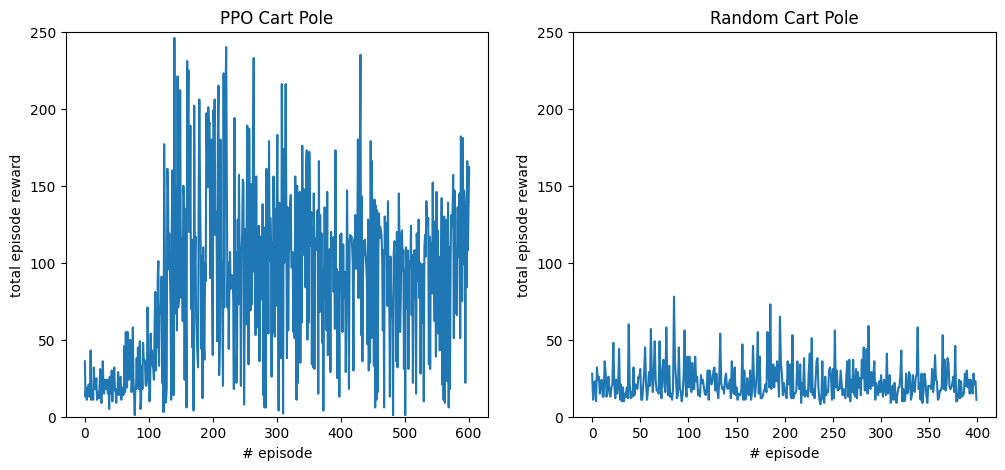

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(ppo_rew)
ax[0].set_ylim(0, 250)
ax[0].set_xlabel("# episode")
ax[0].set_ylabel("total episode reward")
ax[0].set_title("PPO Cart Pole")

ax[1].plot(rew_t)
ax[1].set_ylim(0, 250)
ax[1].set_xlabel("# episode")
ax[1].set_ylabel("total episode reward")
ax[1].set_title("Random Cart Pole")

It looks like PPO actually performed quite a bit better :)

For fun, I also rendered a visualization of the algorithm trying to balance the poll on individual runs. PDFs, however, do not support videos, so [YouTube link must suffice](https://youtu.be/2a_DtFPhi-0).

In [21]:
env = gym.make('CartPole-v1', render_mode='human')

for _ in range(1):
    s, _ = env.reset()
    
    done = False
    while not done:
        a, *_ = agent.choose_action(s)
        s, _, done, _, _ = env.step(a)
    
env.close()

In [26]:
env = gym.make('CartPole-v1', render_mode='human')

for _ in range(1):
    s, _ = env.reset()
    
    done = False
    while not done:
        s, _, done, _, _ = env.step(env.action_space.sample())
    
env.close()

## Lunar Lander

Now, let's move onto a more interesting environment—the lunar lander.

In [39]:
env = gym.make("LunarLander-v2", continuous = False)
obs, info = env.reset()

n_observations = len(obs)
n_actions = 4
agent = PPO(n_observations, n_actions, epochs = 3, batch_size=16, lr=3e-4, device='cpu', clip=0.15)

iters = 500
horizon = 512
done = False

ppo_rew = []

for iter in tqdm(range(iters)):
    ep_rew = 0
    for _ in range(horizon):
        # Get action using policy
        act, val, prob = agent.choose_action(obs)
        # Take a step in environement
        new_obs, rew, done, trun, _ = env.step(act)
        ep_rew += rew
        # Done or truncated
        done = done or trun
        # Group observations together
        observation = [obs, prob, val, act, rew, done]
        # Pass them to memory
        agent.observe(*observation)
        
        # If episode is ended or truncated
        if done:
            # Reset the environment
            new_obs, _ = env.reset()
            done = False
            ppo_rew.append(ep_rew)
            ep_rew = 0

        # Update observation
        obs = new_obs
    # Update agent
    agent.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:07<00:00,  1.62it/s]


In [40]:
random_rew = []
env = gym.make("LunarLander-v2", continuous = False)

for _ in tqdm(range(500)):
    ep_rew = 0
    s, _ = env.reset()
    done = False
    
    while not done:
        s, rew, done, _, _ = env.step(env.action_space.sample())
        ep_rew += rew
        
    random_rew.append(ep_rew)
env.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.55it/s]


Text(0.5, 1.0, 'Random Lunar Lander')

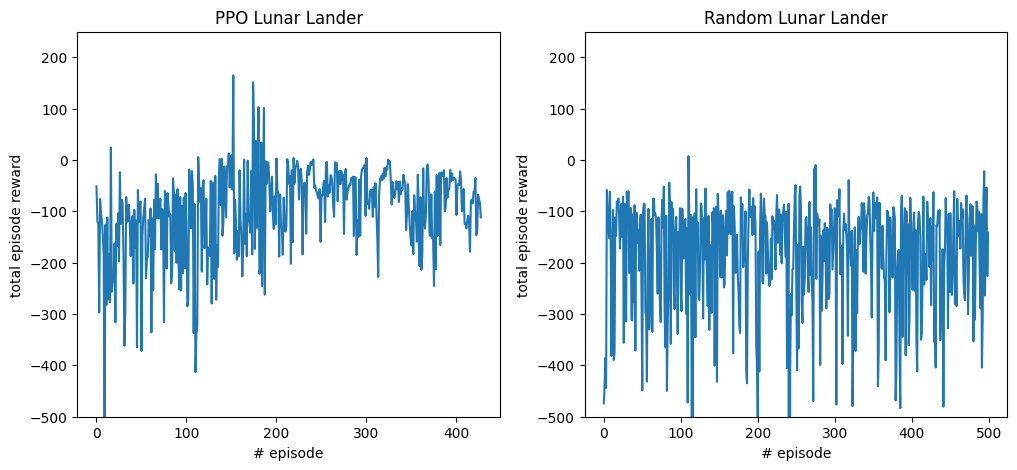

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(ppo_rew)
ax[0].set_ylim(-500, 250)
ax[0].set_xlabel("# episode")
ax[0].set_ylabel("total episode reward")
ax[0].set_title("PPO Lunar Lander")

ax[1].plot(random_rew)
ax[1].set_ylim(-500, 250)
ax[1].set_xlabel("# episode")
ax[1].set_ylabel("total episode reward")
ax[1].set_title("Random Lunar Lander")

After looking at the [video (click at the link to see what I am talking about)](https://youtu.be/BdL5XMVVCnU), it seems that the agent learnt really well how to balance the spacecraft, but it has not learnt how to actually land, which might be the issue with the hyperparameters.

In [44]:
env = gym.make('LunarLander-v2', continuous=False, render_mode='human')

for _ in range(1):
    s, _ = env.reset()
    
    done = False
    while not done:
        a, *_ = agent.choose_action(s)
        s, _, done, trun, _ = env.step(a)
        done = done or trun
    
env.close()

# Executive Summary

In this work, we have introduced the readers to the concept of reinforcement learning. In the first section, we explained in detail how the policy gradient methods are derived and can be used to create agents that maximize the reward. We also introduce the idea behind the TRPO and PPO as the improvements behind the original vanilla policy gradient optimization. We also explained how policymakers and critics could use neural networks to create a well-balanced agent. Lastly, PPO was implemented in code and run on pole balancing and lunar lander environments, where they were compared with a random agent, which was outperformed in both cases. 

# References

Anwar, A. (2021, February 7). Basic Terminologies of Reinforcement Learning. Analytics Vidhya. https://medium.com/analytics-vidhya/basic-terminology-reinforcement-learning-2357fd5f0e51

Gymnasium Documentation. (2022). Farama.org. https://gymnasium.farama.org/environments/box2d/lunar_lander/

Mcneela, D. (n.d.-a). A Tutorial on the REINFORCE (aka Monte-Carlo Policy Differentiation) Algorithm. Mcneela.github.io. Retrieved April 20, 2024, from http://mcneela.github.io/math/2018/04/18/A-Tutorial-on-the-REINFORCE-Algorithm.html

Mcneela, D. (n.d.-b). The Problem with Policy Gradient. Mcneela.github.io. Retrieved April 20, 2024, from https://mcneela.github.io/machine_learning/2019/06/03/The-Problem-With-Policy-Gradient.html

OpenAI. (2022, June 1). Baselines. GitHub. https://github.com/openai/baselines
Proximal Policy Optimization. (n.d.). Openai.com. https://openai.com/research/openai-baselines-ppo

Proximal Policy Optimization — Spinning Up documentation. (2017). Openai.com. https://spinningup.openai.com/en/latest/algorithms/ppo.html

Reinforcement Learning (PPO) with TorchRL Tutorial — torchrl main documentation. (n.d.). Pytorch.org. Retrieved April 20, 2024, from https://pytorch.org/rl/tutorials/coding_ppo.html

Schulman, J., Levine, S., Moritz, P., Jordan, M., & Abbeel, P. (2017). Trust Region Policy Optimization. https://arxiv.org/pdf/1502.05477.pdf

Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Openai, O. (2017). Proximal Policy Optimization Algorithms. https://arxiv.org/pdf/1707.06347.pdf

What is the difference between State Value function and Return for Markov Reward process ( MRP)? (n.d.). Data Science Stack Exchange. Retrieved April 20, 2024, from https://datascience.stackexchange.com/questions/120552/what-is-the-difference-between-state-value-function-and-return-for-markov-reward
